# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import gzip
import pickle
import re

import nltk
import nltk.data
from nltk.tokenize import TreebankWordTokenizer 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer

from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN

# Data import and EDA

In [2]:
data = pd.read_csv("mtsamples.csv")

In [3]:
data.rename(columns={"Unnamed: 0":"index"}, inplace=True)

In [4]:
data.set_index('index', inplace=True)

In [5]:
data.head()

,description,medical_specialty,sample_name,transcription,keywords
index,,,,,
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [6]:
data.columns

Index(['description', 'medical_specialty', 'sample_name', 'transcription',
       'keywords'],
      dtype='object')

we need only the transcription column and the medical specialty as our labels.

In [7]:
data = data[['transcription', 'medical_specialty']]

check for missing values

In [8]:
data.isna().sum()

transcription        33
medical_specialty     0
dtype: int64

remove missing values

In [9]:
data.dropna(inplace=True)
data.shape

(4966, 2)

In [10]:
data.head()

,transcription,medical_specialty
index,,
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",Bariatrics
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",Bariatrics
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary


In [11]:
data.iloc[4]['transcription']

'1.  The left ventricular cavity size and wall thickness appear normal.  The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%.  There is near-cavity obliteration seen.  There also appears to be increased left ventricular outflow tract gradient at the mid cavity level consistent with hyperdynamic left ventricular systolic function.  There is abnormal left ventricular relaxation pattern seen as well as elevated left atrial pressures seen by Doppler examination.,2.  The left atrium appears mildly dilated.,3.  The right atrium and right ventricle appear normal.,4.  The aortic root appears normal.,5.  The aortic valve appears calcified with mild aortic valve stenosis, calculated aortic valve area is 1.3 cm square with a maximum instantaneous gradient of 34 and a mean gradient of 19 mm.,6.  There is mitral annular calcification extending to leaflets and supportive structures with thickening of mitral valve leaflets with mi

Check the unique categories of specialties and their distribution

In [12]:
data['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

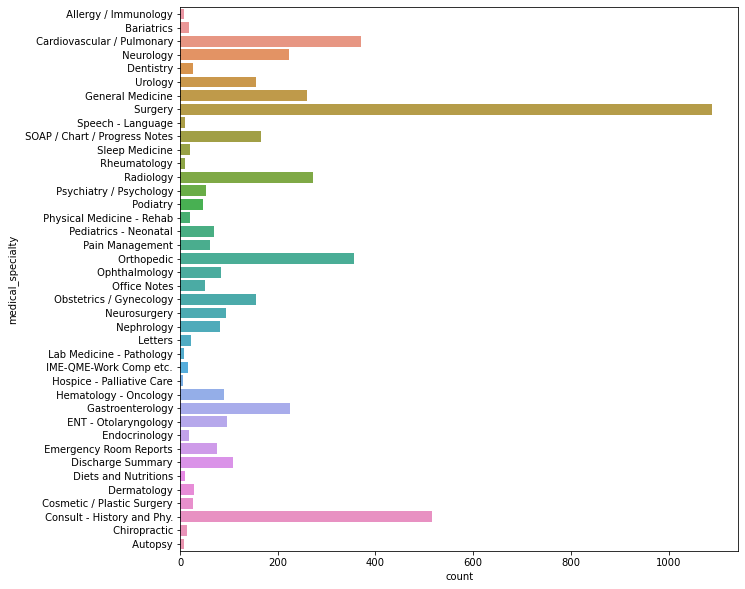

In [13]:
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = data )
plt.show()

## Data labels adjustment

remove the ones with very low reprssentation as the dataset is already imbalances.
and remove surgery as it can reffer to many specialties.\


In [27]:
def hand_feature_engineering(data):
    """
    adjust data labels
    """ 
    replace_dictionairy = {' Pediatrics - Neonatal': ' Other specialty',
                           ' Psychiatry / Psychology': ' Other specialty',
                           ' Dermatology': ' Other specialty',
                           ' Dentistry':' Other specialty',
                           ' Endocrinology': ' Other specialty',
                           ' Rheumatology':' Other specialty'}
    # create a new clas with specialties that have low representation in the dataset | 
    # as refference for further investigation
    data['medical_specialty'].replace(replace_dictionairy, inplace=True)
    # remove classes with extreme values
    counts = data['medical_specialty'].value_counts()
    data = data[data['medical_specialty'].isin(counts[counts > 80].index)]
    data = data[data['medical_specialty'].isin(counts[counts < 600].index)]
    # remove classes not relevant for the model
    values = [' Consult - History and Phy.',' SOAP / Chart / Progress Notes', ' Discharge Summary' ]
    data = data[data['medical_specialty'].isin(values) == False]
    
    return data
    

In [28]:
hand_feature_engineering(data)

,transcription,medical_specialty
index,,
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary
7,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",Cardiovascular / Pulmonary
9,"DESCRIPTION:,1. Normal cardiac chambers size....",Cardiovascular / Pulmonary
11,"2-D STUDY,1. Mild aortic stenosis, widely calc...",Cardiovascular / Pulmonary
...,...,...
4972,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden...",Cardiovascular / Pulmonary
4973,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES...",Cardiovascular / Pulmonary
4974,"HISTORY OF PRESENT ILLNESS: , The patient is a...",Cardiovascular / Pulmonary


In [29]:
data.head()

,transcription,medical_specialty
index,,
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary
7,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",Cardiovascular / Pulmonary
9,"DESCRIPTION:,1. Normal cardiac chambers size....",Cardiovascular / Pulmonary
11,"2-D STUDY,1. Mild aortic stenosis, widely calc...",Cardiovascular / Pulmonary


In [41]:
counts = data['medical_specialty'].value_counts()
counts

 Cardiovascular / Pulmonary    371
 Orthopedic                    355
 Radiology                     273
 General Medicine              259
 Gastroenterology              224
 Neurology                     223
 Other specialty               208
 Urology                       156
 Obstetrics / Gynecology       155
 ENT - Otolaryngology           96
 Neurosurgery                   94
 Hematology - Oncology          90
 Ophthalmology                  83
 Nephrology                     81
Name: medical_specialty, dtype: int64

In [30]:
data['medical_specialty'].unique()

array([' Cardiovascular / Pulmonary', ' Neurology', ' Other specialty',
       ' Urology', ' General Medicine', ' Radiology', ' Orthopedic',
       ' Ophthalmology', ' Obstetrics / Gynecology', ' Neurosurgery',
       ' Nephrology', ' Hematology - Oncology', ' Gastroenterology',
       ' ENT - Otolaryngology'], dtype=object)

In [31]:
data.shape

(2668, 2)

In [32]:
data['totalwords'] = [len(x.split()) for x in data['transcription'].tolist()]

In [33]:
data['totalwords'].unique()

array([  68,  229,  109,   57,   83,  500,  452,  854,  331,  261,  115,
        150,  223,    2,   96,  169,  121,  215,  158,  202,  530,  181,
        210,  288,  108,  364,  292,  307,  622,  443,  519,  118, 1402,
        368,  301,  425, 1116,  649,  398,  727,  938,  609,  294,  151,
        801,  321, 1086,  360,  137,  165,  684, 1391,  265,  405,  122,
        201,  544,  871,  648,  242,  353,  643,  186,  184,  585,  408,
        581,  509,  258,  573,  809,  148,  323,  427,  762,  719,  252,
        749,  423,  670,  234,  401,  384,  359,  101,  283,  369,  209,
        506,  461,  529,  620,  678,  435,  453,  617, 1098,  619,  606,
        460,  357,  269,  330,  489,  446,  190,  228,  458,  105,   90,
        198,   59,  196,  197,  574,  346,  493,  249,  293,  355,  336,
        471,  450,  654,  551,   10,  459,  289,  475,  272,  306, 2008,
        149,   85,  241,  221,  418,  237,  492,  308,  256,  200,  380,
        204,   16,  299,  139,  166,  189, 1354,  6

<BarContainer object of 2668 artists>

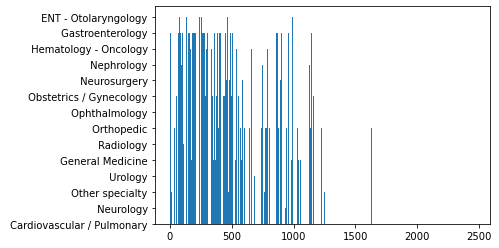

In [34]:
plt.bar(data['totalwords'], data['medical_specialty'])

# Util functions

## Preprocess functions

In [35]:
import contractions
import string

def preprocess(text_col):
    """This function will apply NLP preprocessing lambda functions over a pandas series such as df['text'].
       These functions include converting text to lowercase, removing emojis, expanding contractions, removing punctuation,
       removing numbers, removing stopwords, lemmatization, etc."""
    
    # convert to lowercase
    text_col = text_col.apply(lambda x: ' '.join([w.lower() for w in x.split()]))
    
    # expand contractions  
    text_col = text_col.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))

    # remove punctuation
    text_col = text_col.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
    
    # remove numbers
    text_col = text_col.apply(lambda x: ' '.join(re.sub("[^a-zA-Z]+", " ", x).split()))

    # remove stopwords
    stopwords = [sw for sw in nltk.corpus.stopwords.words('english') if sw not in ['not', 'no']]
    text_col = text_col.apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))
    
    # remove additional words
    additional_word_to_remove = ['patient', 'left', 'right', 'normal', 'history', 'placed', 'day', 'time', 'blood', 
                                'dr', 'medical']
    text_col = text_col.apply(lambda x: ' '.join([w for w in x.split() if w not in additional_word_to_remove]))

    return text_col

## Tokenize and lemmatize text 

In [36]:
MIN_WORDS = 4
MAX_WORDS = 200

In [37]:
def tokenize_text(text,min_words=MIN_WORDS, max_words=MAX_WORDS):
    """
    Lemmatize, tokenize, crop and remove stop words.
    """
    clean_corpus = []
    tokenizer = TreebankWordTokenizer()
    lemmatizer = WordNetLemmatizer()
    tokens = tokenizer.tokenize(text=text)
    token = [w for w in tokens if (len(w) > min_words and len(w) < max_words)]
    clean_doc = " ".join(lemmatizer.lemmatize(token) for token in tokens)
    clean_corpus.append(clean_doc)
    return clean_corpus    

In [38]:
def clean_sentences(df):
    """
    Remove irrelavant characters (in new column clean_corpus).
    Lemmatize, tokenize words into list of words (in new column tok_lem_corpus).
    """
    print('Cleaning sentences...')
    df['clean_corpus'] = preprocess(df['transcription'])
    df['tok_lem_corpus'] = df['clean_corpus'].apply(
        lambda x: tokenize_text(x, min_words=MIN_WORDS, max_words=MAX_WORDS))
    return df



# Preprocess sentences

In [39]:
clean_sentences(data)

Cleaning sentences...


,transcription,medical_specialty,totalwords,clean_corpus,tok_lem_corpus
index,,,,,
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary,68,mmode atrial enlargement atrial diameter cm si...,[mmode atrial enlargement atrial diameter cm s...
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary,229,ventricular cavity size wall thickness appear ...,[ventricular cavity size wall thickness appear...
7,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",Cardiovascular / Pulmonary,109,echocardiogrammultiple views heart great vesse...,[echocardiogrammultiple view heart great vesse...
9,"DESCRIPTION:,1. Normal cardiac chambers size....",Cardiovascular / Pulmonary,57,description cardiac chambers size ventricular ...,[description cardiac chamber size ventricular ...
11,"2-D STUDY,1. Mild aortic stenosis, widely calc...",Cardiovascular / Pulmonary,83,study mild aortic stenosis widely calcified mi...,[study mild aortic stenosis widely calcified m...
...,...,...,...,...,...
4972,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden...",Cardiovascular / Pulmonary,127,indication chest paintype test adenosine nucle...,[indication chest paintype test adenosine nucl...
4973,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES...",Cardiovascular / Pulmonary,355,chief complaint chest painhistory present illn...,[chief complaint chest painhistory present ill...
4974,"HISTORY OF PRESENT ILLNESS: , The patient is a...",Cardiovascular / Pulmonary,1067,present illness yearold woman following angina...,[present illness yearold woman following angin...


In [40]:
corpus = [item for sublist in data['tok_lem_corpus'] for item in sublist]
corpus

['mmode atrial enlargement atrial diameter cm size ventricle lv systolic function ventricular ejection fraction lv diastolic function no pericardial effusion morphology aortic valve mitral valve tricuspid valve pulmonary valve pa systolic pressure mmhgdoppler mild mitral tricuspid regurgitation trace aortic pulmonary regurgitation',
 'ventricular cavity size wall thickness appear wall motion ventricular systolic function appears hyperdynamic estimated ejection fraction nearcavity obliteration seen also appears increased ventricular outflow tract gradient mid cavity level consistent hyperdynamic ventricular systolic function abnormal ventricular relaxation pattern seen well elevated atrial pressure seen doppler examination atrium appears mildly dilated atrium ventricle appear aortic root appears aortic valve appears calcified mild aortic valve stenosis calculated aortic valve area cm square maximum instantaneous gradient mean gradient mm mitral annular calcification extending leaflet su

# Vectorize

In [ ]:
X = corpus
y = data['medical_specialty']

In [ ]:
labels = data['medical_specialty'].tolist()

## Vectorization models

### BAG OF WORDS with Countvectorizer

In [ ]:
vectorizer = CountVectorizer( max_df=0.8, analyzer='word',max_features=1000)
X_new = vectorizer.fit_transform(X)
df_bow_sklearn = pd.DataFrame(X_new.toarray(),columns=vectorizer.get_feature_names(), index=y)
df_bow_sklearn.head()

### Tf - IDF

In [ ]:
vectorizer = TfidfVectorizer(analyzer='word',ngram_range=(1,2), max_df=0.8, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(X)
feature_names = sorted(vectorizer.get_feature_names())
print(feature_names)



Lets visualize the tf-idf features using t-sne plot. T-distributed Stochastic Neighbor Embedding (t-SNE) is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.
The t-sne plot shows that lot of categories are overlapping with each other.


In [ ]:
data['medical_specialty'].nunique()

In [ ]:
import gc
gc.collect()
tfIdfMatrix = tfIdfMat.todense()
labels = data['medical_specialty'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(15,10))
palette = sns.hls_palette(14, l=.6, s=.9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full",
    alpha=0.3
)
plt.show()

# Wordcloud visualisation

We can use wordcloud to show which words are the most frequent among our corpus and in seperate classes.

In [ ]:
# Generate a word cloud image from the whole transcription column
text = ' '.join(data['transcription'].values)
word_cloud = WordCloud(width=600,height=400,
                       max_words=150, background_color="white",
                       collocations=False).generate(text)

plt.figure(figsize=(12,10));
plt.imshow(word_cloud, interpolation='bilinear');
plt.axis('off');


do the same for the clean corpus and see the relevance in the medical terms

In [ ]:
# Generate a word cloud image from the whole transcription column
text = ' '.join(data['clean_corpus'].values)
word_cloud = WordCloud(width=600,height=400,
                       max_words=150, background_color="white",
                       collocations=False).generate(text)

plt.figure(figsize=(12,10));
plt.imshow(word_cloud, interpolation='bilinear');
plt.axis('off');


Observe the different dominant words across the classes 

In [ ]:
def create_word_cloud_from_specialty(df,specialty='Radiology'):
    '''Create a word cloud from a medical specialty
    
    '''
    text = df[df['medical_specialty'] == specialty]['clean_corpus'].values
    text = ' '.join(text)
    word_cloud = WordCloud(width=600,height=400,
                       max_words=150, background_color="white",
                       collocations=False).generate(text)
    plt.figure(figsize=(12,10));
    plt.imshow(word_cloud, interpolation='bilinear');
    plt.axis('off');

In [ ]:
print('List of specialties: ')
print(data['medical_specialty'].unique())

In [ ]:
# iterate through the medical specialties and create word clouds for each
for i in data['medical_specialty'].unique():
    create_word_cloud_from_specialty(data, specialty=i)

Note that most of the classes with high number of samples have more accurate words, whereas specialties like ' SOAP / Chart / Progress Notes', ' Discharge Summary' and ' Consult - History and Phy.' present a lot of generic words that might not help our model. 

In [ ]:
create_word_cloud_from_specialty(data,specialty=' Cardiovascular / Pulmonary')

In [ ]:
create_word_cloud_from_specialty(data,specialty=' Other specialty')

In [ ]:
create_word_cloud_from_specialty(data,specialty=' Obstetrics / Gynecology')

# models

In [ ]:
results = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

In [ ]:
def choose_training_model(model_name, preprocessing_dataset, training_set, y):
    """
    split the data into training and test,
    choose the model,
    fit the data
    and return the result metrics
    """
    
    df = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
    X_train, X_test, y_train, y_test = train_test_split(training_set, y, stratify=y, random_state=1) 
    
    if model_name.lower() == 'logistic regression':
        folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 40)
        model = LogisticRegressionCV(cv = folds, solver = 'saga', multi_class = 'multinomial', n_jobs = -1)
    elif model_name.lower() == 'naive bayes':
        model = MultinomialNB()
    else:
        print('check your spelling!')
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    f1 = f1_score(y_pred, y_test, average = 'weighted')
    pres = precision_score(y_pred, y_test, average = 'weighted')
    rec = recall_score(y_pred, y_test, average = 'weighted')
    acc = accuracy_score(y_pred, y_test)
    
    result = df.append({'Preprocessing': f'{preprocessing_dataset}', 'Model': f'{model_name}', 'Precision': pres,
                            'Recall': rec, 'F1-score': f1, 'Accuracy': acc}, ignore_index = True)

    return result
        
       

## Logistic regression

In [ ]:
results = results.append(choose_training_model('logistic regression', 'BOW', df_bow_sklearn, y))

In [ ]:
results= results.append(choose_training_model('logistic regression', 'tfid', tfIdfMat, y))

## Naive Bayes

In [ ]:
results = results.append(choose_training_model('naive bayes', 'BOW', df_bow_sklearn, y))

In [ ]:
results = results.append(choose_training_model('naive bayes', 'tfid', tfIdfMat, y))

In [ ]:
results

# imbalanced data - Undersampling and Oversampling

In [ ]:
def train_oversample_undersample_models(strategy, model_name, training_set):
    """
    try undersampling and oversampling techniques with logistic regression and naive bayes
    and return the resuls.
    list of sampling techniques = ['SMOTE', 'RandomUndersample', ]
    """
    
    labels = data['medical_specialty'].tolist()
    if strategy.lower() == 'smote':
        smote_over_sample = SMOTE(sampling_strategy='minority')
        X, y = smote_over_sample.fit_resample(training_set, labels)
        return choose_training_model(model_name, 'SMOTE', X, y)
    elif strategy.lower() == 'adasyn':
        adasyn_over_sample = ADASYN(sampling_strategy='minority')
        X, y = adasyn_over_sample.fit_resample(training_set, labels)
        return choose_training_model(model_name, 'ADASYN', X, y)
    elif strategy.lower() == 'undersample naive':
        naive_under_sample = RandomUnderSampler(sampling_strategy = 'majority')
        X, y = naive_under_sample.fit_resample(training_set, labels)
        return choose_training_model(model_name, 'Undersampler Naive', X, y)
    elif strategy.lower() == 'undersample nearmiss':
        near_under_sample = NearMiss(sampling_strategy='majority')
        X, y = near_under_sample.fit_resample(training_set, labels)
        return choose_training_model(model_name, 'Undersampler NearMiss', X, y)
    else:
        print('Check your spelling!')



 

## Undersample Naive

In [ ]:
results = results.append(train_oversample_undersample_models('undersample naive', 'naive bayes', tfIdfMat))

In [ ]:
results = results.append(train_oversample_undersample_models('undersample naive', 'naive bayes', df_bow_sklearn))

In [ ]:
results = results.append(train_oversample_undersample_models('undersample naive', 'logistic regression', tfIdfMat))

In [ ]:
results = results.append(train_oversample_undersample_models('undersample naive', 'logistic regression', df_bow_sklearn))

## Undersample NearMiss

In [ ]:
results = results.append(train_oversample_undersample_models('undersample nearmiss', 'naive bayes', tfIdfMat))

In [ ]:
results = results.append(train_oversample_undersample_models('undersample nearmiss', 'naive bayes', df_bow_sklearn))

In [ ]:
results = results.append(train_oversample_undersample_models('undersample nearmiss', 'logistic regression', tfIdfMat))

In [ ]:
results = results.append(train_oversample_undersample_models('undersample nearmiss', 'logistic regression', df_bow_sklearn))

## Oversample SMOTE

In [ ]:
results = results.append(train_oversample_undersample_models('SMOTE', 'naive bayes', tfIdfMat))

In [ ]:
results = results.append(train_oversample_undersample_models('SMOTE', 'naive bayes', df_bow_sklearn))

In [ ]:
results = results.append(train_oversample_undersample_models('SMOTE', 'logistic regression', tfIdfMat))

In [ ]:
results = results.append(train_oversample_undersample_models('SMOTE', 'logistic regression', df_bow_sklearn))

## Oversample ADASYN

In [ ]:
results = results.append(train_oversample_undersample_models('adasyn', 'naive bayes', tfIdfMat))

In [ ]:
results = results.append(train_oversample_undersample_models('adasyn', 'naive bayes', df_bow_sklearn))

In [ ]:
results = results.append(train_oversample_undersample_models('adasyn', 'logistic regression', tfIdfMat))

In [ ]:
results = results.append(train_oversample_undersample_models('adasyn', 'logistic regression', df_bow_sklearn))

## Results

In [ ]:
results

# Choose model and test samples

As we can see, quality metrics vary a lot. So we need to choose the one we will be targeting on.

    Accuracy is not a good choice as due to very unbalanced class maximizing it will force alorithm to predict the major one;
    Precision indicates how much we can trust the algorithm when it predicts a certain class;
    Recall shows how many of the true labels of the class are predicted correctly by the algorithm;
    F1-score is the harmonic mean of precision and recall.

For basic setup all data preprocessing approaches work closely well. The the combination of the exact algorithm and preprocessing method make the difference. As F1-score is the most balanced one of the metrics above, we will use it primarily, but still keeping an eye on others.

The overall best approach seems to be the tfidf vectorizer on SMOTE trained on Logistic Regression.

In [ ]:
smote_over_sample = SMOTE(sampling_strategy='minority')
X, y = smote_over_sample.fit_resample(tfIdfMat, labels)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X, y, test_size=0.2, random_state=40)

folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 40)
model = LogisticRegressionCV(cv = folds, solver = 'saga', multi_class = 'multinomial', n_jobs = -1)
model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test_smote)




In [ ]:
# save the model to disk
filename = '/home/xrusa/Documents/Projects/model.sav'
pickle.dump(model, open(filename, 'wb'))

## model evaluation

In [ ]:
# create a confussion matrix

labels = data['medical_specialty'].unique()
cm = confusion_matrix(y_test_smote, y_pred, labels)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test_smote,y_pred,labels=labels))



The vast majority of the predictions end up on the diagonal (predicted label = actual label), where we want them to be. However, there are a number of misclassifications

## Metrics

In [ ]:

# define the classes
le = preprocessing.LabelEncoder()

# generate data
target = le.fit_transform(data['medical_specialty'].values)
data = data['clean_corpus'].values
classes = le.classes_

# print results
print('# of classes: {}'.format(len(classes)))
print('Fitted classes:')
print(classes)

In [ ]:
# create a classifiction report
print(classification_report(y_test_smote, y_pred, target_names=classes))

In [ ]:
classes

In [ ]:
label_to_text = {
    0: ' Cardiovascular / Pulmonary',
    1: ' ENT - Otolaryngology',
    2: ' Gastroenterology',
    3: ' General Medicine',
    4: ' Hematology - Oncology',
    5: ' Nephrology',
    6: ' Neurology',
    7: ' Neurosurgery',
    8: ' Obstetrics / Gynecology',
    9: ' Ophthalmology',
    10: ' Orthopedic',
    11: ' Other specialty',
    12: ' Radiology',
    13: ' Urology'
}

In [ ]:
data['medical_specialty'].unique().tolist()

In [ ]:
final_metrics = pd.DataFrame({'Labels': range(14), 
                              'Recall': recall_score(y_pred, y_test_smote, average = None),
                             'Precision': precision_score(y_pred, y_test_smote, average = None),
                             'F1-score': f1_score(y_pred, y_test_smote, average = None)})
final_metrics['Labels'] = final_metrics['Labels'].replace(label_to_text)
final_metrics


## Validation of unknown text

In [ ]:
text_neurology = "77 yo woman presents with significant angioedema in left side of tongue and inner cheek.Possible causes of angioedema include allergic anaphylaxis reaction, drug induced,allergic contact dermatitis, viral infection, drug induced, or a C1 inhibitor deficiencydisorder acquired or hereditary. Laryngeal edema can also be caused by tonsillitis,peritonsilar abscess or pharyngeal foreign body.It is unlikely that the patient has edema caused by abscess or tonsillitis since she does nothave any associated fever or other signs of infection and the sudden onset of her swellingalso argues against this. It is not likely a foreign body since ENT did not find anythingwhen they scoped her.It is unlikely that it is caused by a mast cell mediated etiologigy that increases vascularpermeability through mast cell degranulation and release of inflammatory mediatorsinclude allergic angioedema, autoimmune mast cell release and direct mast cell releasecaused by medications such as opiates and radiocontrast media. It is not likely this typeof reaction because these etiologies are associated with urticaria and pruritis, which thepatient did not have. Also the patient did not have any exposure to a new pet, food,lotion or any other allergen or medication that could cause an allergic type reaction. Thepatient also does not have any history of autoimmune disease or any reaction similar tothis in the pastIt is more likely that the etiology is kinin-related where angioedema results fromgeneration of bradykinin and complement-derived mediators that increase vascularpermeability since there is no urticaria or pruritis. The most likely cause is the Altace(ACEI) that the patient has been taking caused an increase in bradykinin since itdecreases angiotensin 2 which degrades bradykinin. Bradykinin can then interact withvascular receptors increasing vasodilation, vascular permeability, increased cGMP andrelease of nitric oxide. This reaction occurs in .1-7% of patients treated with an ACEIand it typically involves the mouth, lips, tounge, larynx, pharynx and sublottic tissues.Half of these cases usually occur within a week of starting the ACEI but can occur yearslater. This is a class specific reaction not a drug specific and ARBs can cause the samereaction even though these drugs don’t effect the kinin metabolism. 50% of patients withangioedema due to an ARB also had an ACEI induced angioedema (Cicardi, M, Zingale,LC, Bergamschini L, Agostoni, A. Angioedema associated with agniotensin-convertingenzyme inhibitor use: outcome after switching to a different treatment. Arch Intern Med2004; 164:910). Deficiency of C1 inhibitor can cause angioedema since levels ofcomplement are reduced and cause increased bradykinin. This can be due to lack of C1NH or adequate amounts of nonfunctional C1 INH. Other causes of angioedema includeaspirin and NSAIDs since inhibition of cox and enzyme pathyway increases formation ofpro-inflammatory leukotrienes."

In [ ]:
text = 'pelvic pain and discharge, cramps and woman very pain angry'

In [ ]:
print(model.predict(vectorizer.transform([text])))